# Analysis of the Word2Vec Algorithm on the Term Similarity Task

The **goal of this research** is to get a better understanding of the word2vec algorithm, to understand how the various hyperparameters affect the quality of the resulting models. Furthermore, we want to study, how corpus size affects model quality.
The research was done by **Pavel Glazyrin (pav.glazyrin@gmail.com)** in form of a Master thesis at ITMO University, St. Petersburg, under the supervision of **Dr. Gerhard Wohlgenannt**.

**Pavel Glazyrin** trained a large number of word2vec models on Wikipedia corpora of various sizes, with various training hyperparamters (in a grid search style, covering the whole hyperparameter space). We evaluate model quality with an **intrinsic evaluation** approach, using existing **word similarity** and **analogy** datasets.

In this notebook, we analyze the word similarity results, using popular datasets such as WordSim-353, SimLex-999, MEN, etc. We apply Pearson/Spearman correlation between the word similarity scores in the datasets (manually created gold standard), and the scores given by the word2vec models (using cosine similarity between the two terms).

((c) This notebook by Gerhard Wohlgenannt, 2020)

The repository to calculate the scores for a given corpus is found at:
https://github.com/cheklmn/Corpus-sizes-embeddings

**Related work:** Sahlgren and Lenci, 2016,
https://www.aclweb.org/anthology/D16-1099/ made a similar, but smaller, study on the effects of corpus size and term frequency on in word embedding models.



## Word Similarity Datasets:

In `result.csv` we use the following datasets to assess embedding model quality.

* **MEN:** https://staff.fnwi.uva.nl/e.bruni/MEN
* **MTurk:** http://www2.mta.ac.il/~gideon/mturk771.html
* **RG65:** Rubenstein, Herbert, and John B. Goodenough. Contextual correlates of synonymy. Communications of the ACM, 8(10):627–633, 1965.
* **RW** (Stanford Rare Words Dataset): https://nlp.stanford.edu/~lmthang/morphoNLM/
* **SimLex-999:** https://fh295.github.io/simlex.html
* **TR9856** (Multiword Term Relatedness dataset): https://www.aclweb.org/anthology/P15-2069/
* **WS353:** WordSim-353 http://alfonseca.org/eng/research/wordsim353.html

## Algorithms and Parameters

In the analyses in this notebook we focus on **word2vec** (https://arxiv.org/abs/1301.3781) models. (In his master thesis Pavel Glazyrin also experiments with **FastText** (https://research.fb.com/downloads/fasttext/) embedddings.

Firstly, **word2vec** includes two basic algorithms, CBOW (continuous bag of words) and Skip-Gram (SG). Both are trained self-supervised on large text corpora, where CBOW uses context words from a given window (`window-size`) to predict the target word (in the middle), while Skip-Gram predicts the context words from the target.

### The main parameters we study:
* Corpus Size (`word count`): How many words to train the model on. In this notebook we use 1M, 5M, 10M words from randomly chosen articles from Wikipedia.
* `dimension`: size of the embedding vectors to be trained. Usually people use from 50-30. Here we evaluate 100 and 300.
* `window-size`: Number of words to the left and the right of the target word. We experiment with *2*, *5* (default), *10*.
* `Sampling`: use hierarchical sampling (yes/no) - here set to "yes" in all experiments.
* `Cross-sentence`: train with cross-sentence contexts (word window extends into the next sentence): boolean
* `epochs`: number of training epochs, here: 100 for any model.
* `Out of vocabulary`: number of word pairs from the dataset which has OOV words.

### Other dataset columns:
* The dataset also includes a lot of columns regarding bins, in which we analyze the performance of low/mid/high/mixed frequency terms pairs. This will be done in a separate notebook. 



## Relevance of this work

This goal and relevance of this work is as follows:
* Better understand the theoretical and practical details of embedding models and their training parameters
* While pretrained embeddings are typically generated from large corpora such as Wikipedia, many domains have a very different vocabulary and use of language. For those domains, often the number of available training documents is limited. This is why the `word count` (**corpus size**) is a central parameter in this research -- in order to understand what corpus-size is necessary to train model of a certain quality.

## Step 1: Load the datafile and look at basic statistics

In [1]:

import pandas as pd
import matplotlib.pyplot as plt

# read that data file!
df = pd.read_csv('results.csv', index_col=0)
df.head()

,Embedding,Method,Time,Dimension,Window,Word count,Sampling,Cross-sentence,Epochs,Dataset,...,High bin upper bound,Low bin score,Low bin pair count,Middle bin score,Middle bin pair count,High bin score,High bin pair count,Mixed bin score,Mixed bin pair count,General score
0,w2v,CBOW,2020-05-06 02:47:27.506915,100,2,1000000,hs,No,100,MEN,...,1540,-0.086026,301,0.275763,230,0.458966,296,0.112565,2173,0.126147
1,w2v,CBOW,2020-05-06 02:47:27.820542,100,2,1000000,hs,No,100,MTurk,...,586,-0.107427,23,-0.085890,17,0.509618,27,0.204725,220,0.195639
2,w2v,CBOW,2020-05-06 02:47:28.132970,100,2,1000000,hs,No,100,RG65,...,186,NaN,5,-0.107143,7,0.800000,4,0.133621,49,0.189169
3,w2v,CBOW,2020-05-06 02:47:28.523470,100,2,1000000,hs,No,100,RW,...,1004,NaN,57,0.152343,77,0.515233,55,0.174082,1845,0.177550
4,w2v,CBOW,2020-05-06 02:47:28.867138,100,2,1000000,hs,No,100,SimLex-999,...,792,0.080735,91,0.032364,97,0.076347,173,0.099547,638,0.080024


### Structure of the Datafile

Which columns do we have, and what kind of data?

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 0 to 503
Data columns (total 26 columns):
Embedding                504 non-null object
Method                   504 non-null object
Time                     504 non-null object
Dimension                504 non-null int64
Window                   504 non-null int64
Word count               504 non-null int64
Sampling                 504 non-null object
Cross-sentence           504 non-null object
Epochs                   504 non-null int64
Dataset                  504 non-null object
Out of vocabulary        504 non-null int64
Low bin lower bound      504 non-null int64
Low bin upper bound      504 non-null int64
Mid bin lower bound      504 non-null int64
Mid bin upper bound      504 non-null int64
High bin lower bound     504 non-null int64
High bin upper bound     504 non-null int64
Low bin score            480 non-null float64
Low bin pair count       504 non-null int64
Middle bin score         504 non-null float64
Middl

In [3]:
df.describe()

,Dimension,Window,Word count,Epochs,Out of vocabulary,Low bin lower bound,Low bin upper bound,Mid bin lower bound,Mid bin upper bound,High bin lower bound,High bin upper bound,Low bin score,Low bin pair count,Middle bin score,Middle bin pair count,High bin score,High bin pair count,Mixed bin score,Mixed bin pair count,General score
count,504.000000,504.000000,5.040000e+02,504.0,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,504.000000,480.000000,504.000000,504.000000,504.000000,504.000000,504.00000,504.000000,504.000000,504.000000
mean,200.000000,5.666667,5.333333e+06,100.0,406.404762,1.047619,36.738095,37.023810,156.857143,159.547619,3637.571429,0.168289,107.190476,0.339235,92.047619,0.489058,121.52381,0.303245,2028.380952,0.296496
std,100.099354,3.303110,3.685445e+06,0.0,643.274577,0.213170,38.463156,38.576142,136.833530,140.634156,3340.685927,0.220892,118.764864,0.279566,88.706262,0.217883,114.44941,0.197127,3118.996917,0.183613
min,100.000000,2.000000,1.000000e+06,100.0,0.000000,1.000000,3.000000,3.000000,13.000000,13.000000,142.000000,-0.785714,5.000000,-0.571429,7.000000,-0.400000,4.00000,0.047424,45.000000,0.046936
25%,100.000000,2.000000,1.000000e+06,100.0,6.000000,1.000000,9.000000,9.000000,38.000000,38.000000,792.000000,0.026465,22.000000,0.164255,21.000000,0.399365,27.00000,0.125694,123.000000,0.140605
50%,200.000000,5.000000,5.000000e+06,100.0,47.500000,1.000000,20.000000,22.000000,123.000000,124.000000,3006.500000,0.194250,91.000000,0.325511,84.500000,0.540970,94.00000,0.242842,625.500000,0.219695
75%,300.000000,10.000000,1.000000e+07,100.0,630.000000,1.000000,55.000000,56.000000,258.000000,258.000000,5662.000000,0.301637,109.000000,0.560042,121.000000,0.659766,179.00000,0.466155,1916.000000,0.469750
max,300.000000,10.000000,1.000000e+07,100.0,1798.000000,2.000000,169.000000,170.000000,611.000000,625.000000,15615.000000,0.900000,445.000000,0.874722,313.000000,0.900000,385.00000,0.774038,9527.000000,0.714991


In [4]:
df.shape, df[df.Embedding == 'w2v'].shape

((504, 26), (504, 26))

Ok, the previous cell shows us, that all enties in column Embedding == 'w2vv'

## Step 2: Simple Overall Comparison of Hyperparameters, based on "General Score"

In [5]:
# define the stats that we want to see for the simple comparision
# in this first evaluation, we just look at the general score
stats_dict = {'General score':  # column to look at 
              ['count','mean','median', 'max', 'min'] # functions to call
             }

In [6]:
parameter_of_interest = "Method"
df[[parameter_of_interest, 'General score']].groupby(parameter_of_interest).agg(stats_dict)

General score                                        
               count      mean    median       max       min
Method                                                      
CBOW             252  0.263089  0.192500  0.597169  0.046936
SG               252  0.329903  0.234932  0.714991  0.075366

**Preliminary Interpretation**: overall Skip-Gram clearly seems to be better ()


---

In [7]:
parameter_of_interest = "Dimension"
df[[parameter_of_interest, 'General score']].groupby(parameter_of_interest).agg(stats_dict)

General score                                        
                  count      mean    median       max       min
Dimension                                                      
100                 252  0.301526  0.226194  0.714991  0.072205
300                 252  0.291465  0.215476  0.713441  0.046936

**Preliminary Interpretation**: surprisingly, smaller vectors (100 dim) are slightly better 


---

In [8]:
parameter_of_interest = "Window"
df[[parameter_of_interest, 'General score']].groupby(parameter_of_interest).agg(stats_dict)

General score                                        
               count      mean    median       max       min
Window                                                      
2                168  0.291747  0.208176  0.691830  0.072004
5                168  0.300102  0.228046  0.714991  0.072205
10               168  0.297637  0.224591  0.713441  0.046936

**Preliminary Interpretation**: word window has little effect, `window_size=5` seems best 


---

In [9]:
parameter_of_interest = "Word count"
df[[parameter_of_interest, 'General score']].groupby(parameter_of_interest).agg(stats_dict)

General score                                        
                   count      mean    median       max       min
Word count                                                      
1000000              168  0.202546  0.153770  0.553157  0.046936
5000000              168  0.313887  0.328894  0.663613  0.072004
10000000             168  0.373054  0.424622  0.714991  0.073498

**Preliminary Interpretation**: as expected, the `training corpus size` has a large impact on model quality. Here we only have 3 sizes (1M, 5M, 10M tokens), but with the tool at **TODO** any size of corpus can be tried. The mean score over all datasets is only *0.20* for a 1M token training corpus, while it is *0.37* for 10M tokens.


---

Let's visualize the results per `word count` group

In [10]:
df[["Word count", 'General score']] \
    .groupby(parameter_of_interest) \
    .agg(['max'])

,General score
,max
Word count,
1000000,0.553157
5000000,0.663613
10000000,0.714991


Text(0, 0.5, 'General score')

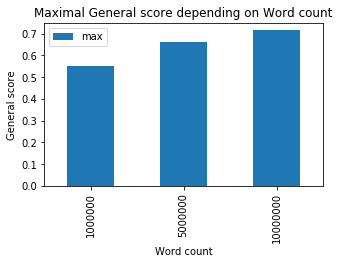

In [11]:
parameter_of_interest = "Word count"
ax = df[["Word count", 'General score']] \
    .groupby(parameter_of_interest) \
    .agg(['max']) \
    .plot.bar(y="General score", title="Maximal General score depending on Word count", figsize=(5,3))
ax.set_ylabel('General score')



In [12]:
parameter_of_interest = "Cross-sentence"
df[[parameter_of_interest, 'General score']].groupby(parameter_of_interest).agg(stats_dict)

General score                                        
                       count      mean    median       max       min
Cross-sentence                                                      
No                       252  0.291213  0.215476  0.714991  0.046936
Yes                      252  0.301778  0.230466  0.712594  0.073498

**Preliminary Interpretation**: cross-sentence word windows seem a bit better, but we have to check later if this is
    also true for large corpora and large word-windows


---

In [13]:
parameter_of_interest = "Dataset"
df[[parameter_of_interest, 'General score']].groupby(parameter_of_interest).agg(stats_dict)

General score                                        
                   count      mean    median       max       min
Dataset                                                         
MEN                   72  0.400354  0.452537  0.647408  0.084276
MTurk                 72  0.382553  0.426363  0.554407  0.099504
RG65                  72  0.338697  0.304597  0.603141  0.144523
RW                    72  0.171207  0.169500  0.238101  0.101282
SimLex-999            72  0.150370  0.156038  0.219600  0.046936
TR9856                72  0.092223  0.093492  0.108517  0.072004
WS353                 72  0.540065  0.546454  0.714991  0.310109

**Preliminary Interpretation**: there are large differences between datasets. Some datasets like WordSim-353 or MEN focus rather on semantic relatedness, while others, like SimLex-999, have a strict definition of similary. In SimLex-999, similarity does not include relatedness or assocation. Word embeddings are well suited to find relatedness and association, but struggle with a strict notion of similarity.


---

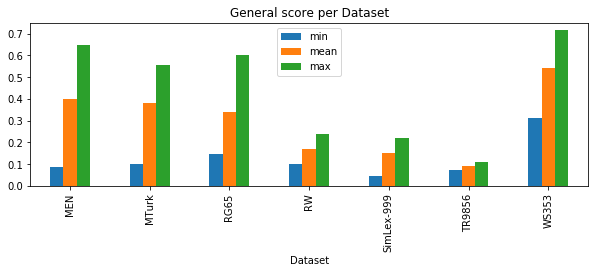

In [14]:
parameter_of_interest = "Dataset"
ax = df[["Dataset", 'General score']] \
    .groupby(parameter_of_interest) \
    .agg(['min', 'mean', 'max']) \
    .plot.bar(y="General score", title="General score per Dataset", figsize=(10,3))


In [15]:
df.plot??

### Step 3: Deeper Analysis of General score

In [16]:
parameters_of_interest = ["Method", "Word count"]
df[parameters_of_interest + ['General score']].groupby(parameters_of_interest).agg(stats_dict)

General score                                        
                          count      mean    median       max       min
Method Word count                                                      
CBOW   1000000               84  0.175200  0.138033  0.469992  0.046936
       5000000               84  0.278928  0.297443  0.527168  0.072004
       10000000              84  0.335138  0.346308  0.597169  0.073498
SG     1000000               84  0.229892  0.181794  0.553157  0.091272
       5000000               84  0.348847  0.373293  0.663613  0.075366
       10000000              84  0.410970  0.496882  0.714991  0.077567

**Interpretation**: Skip-gram is superior for all 3 corpus sizes.

---

In [17]:
parameters_of_interest = ["Method", "Window"]
df[parameters_of_interest + ['General score']].groupby(parameters_of_interest).agg(stats_dict)

General score                                        
                      count      mean    median       max       min
Method Window                                                      
CBOW   2                 84  0.273459  0.190477  0.597169  0.072004
       5                 84  0.265518  0.204941  0.591147  0.072205
       10                84  0.250288  0.184826  0.590560  0.046936
SG     2                 84  0.310036  0.219695  0.691830  0.075366
       5                 84  0.334686  0.240163  0.714991  0.086918
       10                84  0.344987  0.261225  0.713441  0.091272

**Interpretation**: it seems, that for Skip-gram a larger word window helps. **Interestingly**, for CBOW a smaller word window seems to work best, while Skip-gram benefits from a larger word window.
    
But let's dig into this, is a large window always best for Skip-gram, or only for small corpora, where we need as much context as we can get to learn.

---

In [18]:
# check only for SkipGram models
df_sg = df[df.Method == 'SG']
parameters_of_interest = ["Word count", "Window"]
df_sg[parameters_of_interest + ['General score']].groupby(parameters_of_interest).agg(stats_dict)


General score                                        
                          count      mean    median       max       min
Word count Window                                                      
1000000    2                 28  0.209942  0.170645  0.526648  0.093767
           5                 28  0.229773  0.198455  0.544154  0.098359
           10                28  0.249962  0.218314  0.553157  0.091272
5000000    2                 28  0.329305  0.334106  0.606622  0.075366
           5                 28  0.355823  0.360693  0.663613  0.086918
           10                28  0.361411  0.400470  0.658317  0.092541
10000000   2                 28  0.390860  0.463992  0.691830  0.077567
           5                 28  0.418462  0.508927  0.714991  0.091963
           10                28  0.423587  0.519674  0.713441  0.093430

**Interpretation**: interesting, so it seem the best hyperparameter combination includes:
        **10M token**, **Skip-Gram**, and **window-size=5**. Although, the means of **window-size=5** and **window-size=10** are very similar.
        
So for a large corpus, we don't necessarily need a large window (which also gives us less related context words).

---

In [19]:
parameters_of_interest = ["Word count", "Dataset"]
df[parameters_of_interest + ['General score']].groupby(parameters_of_interest).agg(stats_dict)

General score                                        
                              count      mean    median       max       min
Word count Dataset                                                         
1000000    MEN                   24  0.166935  0.145151  0.268883  0.084276
           MTurk                 24  0.215665  0.225663  0.303572  0.099504
           RG65                  24  0.230459  0.215215  0.395132  0.144523
           RW                    24  0.141472  0.145790  0.190963  0.101282
           SimLex-999            24  0.106588  0.102118  0.178673  0.046936
           TR9856                24  0.100901  0.100902  0.108517  0.089998
           WS353                 24  0.455803  0.476798  0.553157  0.310109
5000000    MEN                   24  0.477359  0.466571  0.589642  0.351152
           MTurk                 24  0.439876  0.460508  0.525712  0.318933
           RG65                  24  0.337127  0.345776  0.477303  0.184920
           RW                    24  0.169419  0.178266  0.218245  0.106153
           SimLex-999            24  0.151779  0.154398  0.192686  0.114558
           TR9856                24  0.088503  0.086927  0.107261  0.072004
           WS353                 24  0.533147  0.517796  0.663613  0.415141
10000000   MEN                   24  0.556769  0.549268  0.647408  0.461683
           MTurk                 24  0.492119  0.495266  0.554407  0.416839
           RG65                  24  0.448505  0.457792  0.603141  0.286873
           RW                    24  0.202730  0.209282  0.238101  0.144184
           SimLex-999            24  0.192742  0.193202  0.219600  0.165105
           TR9856                24  0.087267  0.085919  0.102034  0.073498
           WS353                 24  0.631244  0.604177  0.714991  0.540167

**Interpretation**: As expected, a larger corpus has a positive impact for all datasets (except TR9856, where word embeddings don't manage to solve the task at all.)


---

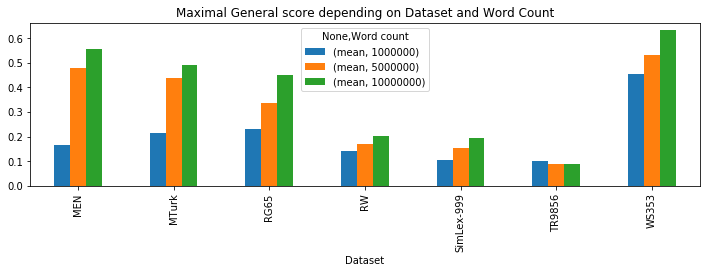

In [20]:
parameters_of_interest = ["Dataset", "Word count"]
#df[parameters_of_interest + ['General score']].groupby(parameters_of_interest).agg(stats_dict)

title = 'Maximal General score depending on Dataset and Word Count'
ax = df[parameters_of_interest + ['General score']] \
    .groupby(parameters_of_interest) \
    .agg(['mean']) \
    .unstack()  \
    .plot.bar(y="General score", title=title, figsize=(12,3))

# remark: .unstack() needed to plot nicely!!

Let's look at "Out of vocabulary", maybe we find the reasons there (eg. for the bad performance of TR9856).


In [21]:
parameter_of_interest = "Dataset"

df[[parameter_of_interest, 'Out of vocabulary']].groupby(parameter_of_interest).agg(
              ['count','mean','median', 'max', 'min'] # functions to call
)

Out of vocabulary                                 
                       count         mean  median   max   min
Dataset                                                      
MEN                       72    47.666667    26.5   109     9
MTurk                     72    81.000000    75.5   102    66
RG65                      72     2.833333     1.0     8     0
RW                        72   935.833333   848.0  1333   627
SimLex-999                72    19.333333     7.0    49     3
TR9856                    72  1752.833333  1739.5  1798  1723
WS353                     72     5.333333     3.0    14     0

**Preliminary Interpretation**: unfortunatly we don't have the number of word pairs per dataset in our `result.csv`, but we see there is high number of OOV pairs in TR9856. TR9856 includes a high number of multiword phrases!

Let's add some data, a column with the number of pairs, and the ratio of OOV pairs!

TODO: ask Pavel: do we use avg vectors for phrases, or are they just OOV?


---

ok, so let's add the dataset_size and `Ratio oov pairs`

In [22]:
import numpy as np
df = df.assign(dataset_size=np.NaN) # init column as NaN

In [23]:
ds_sizes = {
    'MEN': 3000,
    'MTurk': 771,
    'RG65': 65,
    'RW': 2034,
    'SimLex-999':999,
    'TR9856': 9856,
    'WS353': 353
}

# set the dataset size into the dataframe df
for ds, size in ds_sizes.items():
    df.loc[df['Dataset'] == ds, ['dataset_size']] = size

df[['Dataset', 'dataset_size']].head(10) # check all is fine

,Dataset,dataset_size
0,MEN,3000.0
1,MTurk,771.0
2,RG65,65.0
3,RW,2034.0
4,SimLex-999,999.0
5,TR9856,9856.0
6,WS353,353.0
7,MEN,3000.0
8,MTurk,771.0
9,RG65,65.0


In [24]:
df["Ratio oov pairs"] = df["Out of vocabulary"] / df["dataset_size"] # set ratio of OOV pairs!

df[['Dataset', 'dataset_size', "Out of vocabulary", "Ratio oov pairs" ]].head(10) # check all is fine


,Dataset,dataset_size,Out of vocabulary,Ratio oov pairs
0,MEN,3000.0,106,0.035333
1,MTurk,771.0,102,0.132296
2,RG65,65.0,8,0.123077
3,RW,2034.0,1329,0.653392
4,SimLex-999,999.0,46,0.046046
5,TR9856,9856.0,1793,0.181920
6,WS353,353.0,14,0.039660
7,MEN,3000.0,106,0.035333
8,MTurk,771.0,102,0.132296
9,RG65,65.0,8,0.123077


ok, now finally let's see what whole `ratio oov pairs` and `General score` the model per dataset have

In [25]:

parameter_of_interest = "Dataset"
tmp_stats_dict = {'General score':  # column to look at 
              ['count','mean','median', 'max', 'min'], # functions to call
              'Ratio oov pairs':  # column to look at 
              ['count','mean','median', 'max', 'min'] # functions to call
             }

tmp_res = df[[parameter_of_interest, 'Ratio oov pairs', 'General score']].groupby(parameter_of_interest).agg(
              tmp_stats_dict # functions to call
)
tmp_res


General score                                          \
                   count      mean    median       max       min   
Dataset                                                            
MEN                   72  0.400354  0.452537  0.647408  0.084276   
MTurk                 72  0.382553  0.426363  0.554407  0.099504   
RG65                  72  0.338697  0.304597  0.603141  0.144523   
RW                    72  0.171207  0.169500  0.238101  0.101282   
SimLex-999            72  0.150370  0.156038  0.219600  0.046936   
TR9856                72  0.092223  0.093492  0.108517  0.072004   
WS353                 72  0.540065  0.546454  0.714991  0.310109   

           Ratio oov pairs                                          
                     count      mean    median       max       min  
Dataset                                                             
MEN                     72  0.015889  0.008833  0.036333  0.003000  
MTurk                   72  0.105058  0.097925  0.132296  0.085603  
RG65                    72  0.043590  0.015385  0.123077  0.000000  
RW                      72  0.460095  0.416912  0.655359  0.308260  
SimLex-999              72  0.019353  0.007007  0.049049  0.003003  
TR9856                  72  0.177844  0.176491  0.182427  0.174817  
WS353                   72  0.015109  0.008499  0.039660  0.000000


**Interpretation**: 

1. ok, datasets where we have good results (MEN, WS353), we have a low ratio of OOV 
2. RW has a high number of OOV (after all, it consists of "rare words"), and has rather low results, fine.
3. SimLex-999 has a low ratio of OOV, but still bad general results. But we already discussed, SimLex-999 is hard for embedding models.
4. TR9856 has a rather high ratio of OOV, but the main difficulty is, that it contains mostly phrases, not words.

Finally about this topic, let's compute the **correlation** between `Ratio oov pairs` and `General score`

---

In [26]:
tmp1 = tmp_res['General score']['mean']
tmp2 = tmp_res['Ratio oov pairs']['mean']

tmp1.corr(tmp2)

-0.5114955793492981


**Interpretation**: Well, as expected we have a negative correlation, that is a higher `Ratio oov pairs` correlates with a lower number in the `General score`


---

Let's move on to other parameters, for example the hyperparameter `Cross-sentence` 

In [27]:
parameters_of_interest = ["Cross-sentence", "Window"]
df[parameters_of_interest + ['General score']].groupby(parameters_of_interest).agg(stats_dict)

General score                                        
                              count      mean    median       max       min
Cross-sentence Window                                                      
No             2                 84  0.284649  0.201215  0.647431  0.072004
               5                 84  0.295256  0.221938  0.714991  0.072205
               10                84  0.293735  0.217197  0.713441  0.046936
Yes            2                 84  0.298846  0.214245  0.691830  0.074597
               5                 84  0.304949  0.252444  0.712594  0.073498
               10                84  0.301540  0.240672  0.709605  0.078567

**Interpretation**: Over all window-sizes, `cross_sentence` has a slight positive impact

---

In [28]:
parameters_of_interest = ["Cross-sentence", "Word count"]
df[parameters_of_interest + ['General score']].groupby(parameters_of_interest).agg(stats_dict)

General score                                \
                                  count      mean    median       max   
Cross-sentence Word count                                               
No             1000000               84  0.197491  0.159618  0.551986   
               5000000               84  0.302214  0.282975  0.639310   
               10000000              84  0.373936  0.438004  0.714991   
Yes            1000000               84  0.207602  0.148187  0.553157   
               5000000               84  0.325561  0.369376  0.663613   
               10000000              84  0.372172  0.424622  0.712594   

                                     
                                min  
Cross-sentence Word count            
No             1000000     0.046936  
               5000000     0.072004  
               10000000    0.076457  
Yes            1000000     0.084276  
               5000000     0.082550  
               10000000    0.073498

**Interpretation**: results are in line with intuition. On a small corpus, cross-sentence helps to provide additional training data from cross-sentence contexts. But on larger corpora, where training is less sparse, 
cross-sentence might even be harmful, as cross-sentence contexts may include potentially unrelated contextual data.

---

Finally, let's study the `Dimension` hyperparameter

In [29]:
parameters_of_interest = ["Word count", "Dimension"]
res = df[parameters_of_interest + ['General score']].groupby(parameters_of_interest).agg(stats_dict)
res

General score                                        
                             count      mean    median       max       min
Word count Dimension                                                      
1000000    100                  84  0.210071  0.178112  0.551986  0.072205
           300                  84  0.195022  0.146555  0.553157  0.046936
5000000    100                  84  0.319224  0.368386  0.663613  0.073124
           300                  84  0.308551  0.306915  0.644301  0.072004
10000000   100                  84  0.375284  0.420463  0.714991  0.073498
           300                  84  0.370823  0.425070  0.713441  0.076105

**Interpretation**: `Dimension` has rather little impact, but it seems that for a small training corpus, lower dimensional embeddings work better; which makes some intuitive sense.
    
---

In [30]:
df.columns

Index(['Embedding', 'Method', 'Time', 'Dimension', 'Window', 'Word count',
       'Sampling', 'Cross-sentence', 'Epochs', 'Dataset', 'Out of vocabulary',
       'Low bin lower bound', 'Low bin upper bound', 'Mid bin lower bound',
       'Mid bin upper bound', 'High bin lower bound', 'High bin upper bound',
       'Low bin score', 'Low bin pair count', 'Middle bin score',
       'Middle bin pair count', 'High bin score', 'High bin pair count',
       'Mixed bin score', 'Mixed bin pair count', 'General score',
       'dataset_size', 'Ratio oov pairs'],
      dtype='object')

In [31]:
best_df = df.loc[(df['Method'] == "SG") & (df['Word count']==10000000), :]
len(best_df)



84

## Step 4: some more analysis


Find out which is the single setting with the highest average score over all datasets

In [32]:
# let's first remove the TR9856 .. it doesn't give useful results


df = df.drop(df[df.Dataset == "TR9856"].index)
print(len(df))
df.reset_index()


parameter_of_interest = "Dataset"
maxidxs = df[[parameter_of_interest, 'General score']].groupby(parameter_of_interest).idxmax()
maxidxs

432


,General score
Dataset,
MEN,497
MTurk,344
RG65,352
RW,367
SimLex-999,466
WS353,349


In [33]:
df.loc[list(maxidxs["General score"]),['Method','Dimension','Word count', 'Ratio oov pairs', \
                                       'Window','Cross-sentence','Dataset', 'General score']]


,Method,Dimension,Word count,Ratio oov pairs,Window,Cross-sentence,Dataset,General score
497,SG,300,10000000,0.003000,10,Yes,MEN,0.647408
344,SG,100,10000000,0.086900,5,No,MTurk,0.554407
352,SG,100,10000000,0.000000,10,No,RG65,0.603141
367,SG,300,10000000,0.309735,5,No,RW,0.238101
466,SG,100,10000000,0.004004,2,Yes,SimLex-999,0.219600
349,SG,100,10000000,0.000000,5,No,WS353,0.714991


**Interpretation**: let's look at the table about, we see that except of parameters `Method=SG` and `Word count=10M` there are no clear winners. Regarding `Dimension`, 4 times 100 was best, 2 times 300. For `Cross-sentence` and `Window` the situation is not clear. 


**Conclusion**: in any given situation, given the domain and corpus size, the parameters have been experimented with (with the help of our tool at TODO). The work here can give some guidelines and intuitions.

---

### Which are the worst settings / results?

In [34]:
df.sort_values(by='General score', ascending=True).head()

,Embedding,Method,Time,Dimension,Window,Word count,Sampling,Cross-sentence,Epochs,Dataset,...,Low bin pair count,Middle bin score,Middle bin pair count,High bin score,High bin pair count,Mixed bin score,Mixed bin pair count,General score,dataset_size,Ratio oov pairs
39,w2v,CBOW,2020-05-06 02:55:27.715509,300,10,1000000,hs,No,100,SimLex-999,...,91,-0.125759,97,0.025723,173,0.082213,638,0.046936,999.0,0.046046
11,w2v,CBOW,2020-05-06 02:48:44.111163,100,5,1000000,hs,No,100,SimLex-999,...,91,0.101220,97,0.036124,173,0.092183,638,0.072205,999.0,0.046046
32,w2v,CBOW,2020-05-06 02:53:32.718013,300,5,1000000,hs,No,100,SimLex-999,...,91,0.046671,97,0.010879,173,0.108363,638,0.074127,999.0,0.046046
25,w2v,CBOW,2020-05-06 02:51:44.874774,300,2,1000000,hs,No,100,SimLex-999,...,91,0.075695,97,0.067095,173,0.085077,638,0.074578,999.0,0.046046
4,w2v,CBOW,2020-05-06 02:47:28.867138,100,2,1000000,hs,No,100,SimLex-999,...,91,0.032364,97,0.076347,173,0.099547,638,0.080024,999.0,0.046046


We can see, that SimLex-999 is the hardest dataset (except TR9856). Results are worst with `CBOW`, `Word count=1M`, `Cross-sentence=False`.

In [52]:
df.iloc[1:3,0:2]

,Embedding,Method
1,w2v,CBOW
2,w2v,CBOW
